In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [8]:
# ------------ The Parameters ----------#
v_bar = 1   # mean value of utility
var = 1     # variance of value function
price = 0   # price
T = 1500     # periods
S = 150     # evaluation time
gamma = 1   # CRRA para
L = 20      # string length
J = 30      # population size
MIN = -4    # min value of alpha
MAX = 4     # max value of alpha
seq = [0,1] # possible bit in a string
iniPOP = 60 # initial population size
iniMUT = 0.08  # mutation rate
CROSS = 0.4 # crossover rate

# mutation rate decays exponentially with rate gMUT
halflife = 250
gMUT = np.log(0.5)/halflife

In [9]:
# ------------ The Model ----------#
""" a class of portfolios to store attributes"""
class Portfolio():
    # Constructor
    def __init__(self, ruleStr):
        self.ruleStr = ruleStr
        self.alpha, self.s = self.find_values(self.ruleStr)
        self.V = 0 #default value for V

    # represent a portfolio
    def __str__(self):
        return self.ruleStr

    # get the alpha of a portfolio
    def find_values(self, ruleStr):
        # find alpha from the rule String
        alpha = MIN
        for j in range(len(ruleStr)):
            x = int(ruleStr[j])*(2**(j-1))/(2**(L - 1))
            alpha += (MAX-MIN)*x
        
        # find s from the rule String and alpha
        s = alpha*(v_bar - price)
        return alpha, s

# ------- Useful function ----------#
def update_V(s):
    V = 0
    for i in range(S):
        d = random.gauss(v_bar, var)
        w = s*(d-price)
        u = -np.exp(-gamma*w)
        V += u
    return V

In [10]:
# ------------ The GA Algorithm ----------#

""" a function to select the best parents based on the valuation"""
def parent_select(population, n_parents):
    # list of selected parents
    parents = []
    # sort the portfolios based on their payoff
    sortedPOP = sorted(
        population, 
        key= lambda parent: parent.V, 
        reverse=True)
    # select the first n parents
    for i in range(n_parents):
        parents.append(sortedPOP[i])
    return parents

""" a function to perform crossover between 2 parents string """
def crossover(parent1, parent2, crossover_rate):
    # define the length of the parents string
    length = len(parent1)
    # define the child strings
    child1 = ""
    child2 = ""
    # if a random value is smaller than CROSS, perform crossover
    if random.uniform(0,1) < crossover_rate:
        # define the crossover point
        cross_point = random.randint(0, length-1)
        # define the child strings
        child1 = parent1[0:cross_point] + parent2[cross_point:length]
        child2 = parent2[0:cross_point] + parent1[cross_point:length]
    else:
        child1 = parent1
        child2 = parent2
    return child1, child2

""" define a function to perform mutation on a child string """
def mutate(child, mutation_rate):
    # define the length of the child string
    length = len(child)
    # define the mutated child string
    mutated_child = ""
    # if a random value is smaller than MUT, perform mutation
    for bit in child:
        if random.uniform(0,1) < mutation_rate:
            if bit == "1":
                mutated_child += "0"
            else:
                mutated_child += "1"
        else:
            mutated_child += bit
    return mutated_child

""" a function to perform genetic algorithm """
def ga_update(population, n_parents, mutation_rate, crossover_rate):
    # select the best parents for ga
    parents = parent_select(population, n_parents)
    # retain the parents in the new population
    new_portfolioList = parents
    # shuffle the parents
    parents_pairs = random.sample(parents, len(parents))
    # perform ga crossover and mutation to create new list of children strings
    children_list = []
    for i in range(0, n_parents, 2):
        child1, child2 = crossover(parents_pairs[i].ruleStr, parents_pairs[i+1].ruleStr, CROSS)
        mutated_child1 = mutate(child1, mutation_rate)
        mutated_child2 = mutate(child2, mutation_rate)
        children_list.append(mutated_child1)
        children_list.append(mutated_child2)
    for i in range(len(children_list)):
        new_portfolioList.append(Portfolio(children_list[i]))
    return new_portfolioList

""" an alternative function to perform genetic algorithm """
def ga_update2(population, n_parents, mutation_rate, crossover_rate):
    parents = parent_select(population, n_parents)
    portfolioList = parents
    parents_pairs = random.sample(parents, len(parents))
    # crossover
    for i in range(0, n_parents, 2):
        child1, child2 = crossover(parents_pairs[i].ruleStr, parents_pairs[i+1].ruleStr, CROSS)
        child1 = Portfolio(child1)
        child2 = Portfolio(child2)
        portfolioList.append(child1)
        portfolioList.append(child2)
    # mutate all population
    new_portfolioList = []
    for portfolio in portfolioList:
        new_ruleStr = mutate(portfolio.ruleStr, mutation_rate)
        new_portfolioList.append(Portfolio(new_ruleStr))
    return new_portfolioList


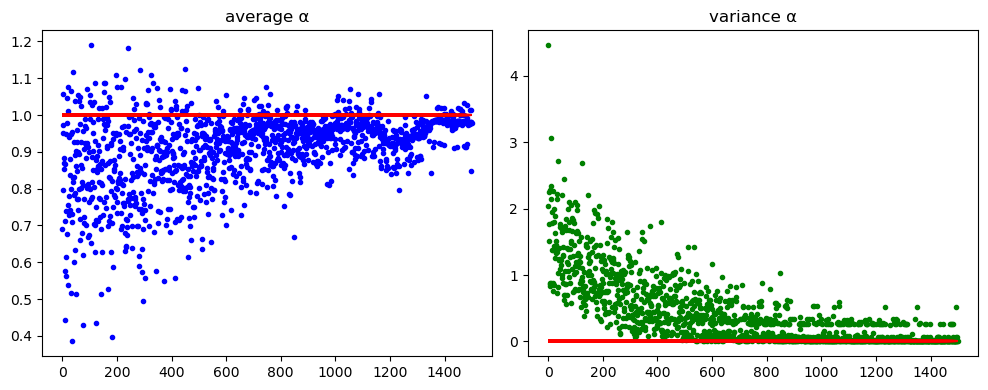

In [11]:
# ------------ The Simulation ----------#
# a function to create a random population of string
def gen_pop(string_length):
    ruleStr = ''
    for i in range(string_length):
        ruleStr+=str(random.choice(seq))
    return ruleStr

# initialize a random population of portfolios
original_portfolioList = []
for i in range(iniPOP):
    ruleStr = gen_pop(L)
    original_portfolioList.append(Portfolio(ruleStr))

# before simulation, select the parents 
for portfolio in original_portfolioList:
    portfolio.V = update_V(portfolio.s)

# then add to the original
portfolioList = parent_select(original_portfolioList, 30)

# plot elements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# runs the simulation for T times
for t in range(T):
    MUT = iniMUT*np.exp(gMUT*t)
    # valuate each portfolio
    for portfolio in portfolioList:
        portfolio.V = update_V(portfolio.s)
    # update population using GA (replace old population)
    portfolioList = ga_update2(portfolioList, J, MUT, CROSS)
    # extract average parameters
    alphaList = [portfolio.alpha for portfolio in portfolioList]
    alphaMean = sum(alphaList)/len(alphaList)
    alphaVar = np.var(alphaList)
    # plot
    ax1.scatter(t, alphaMean, color='blue', marker='.')
    ax1.hlines(y=1, xmin=0, xmax=t, colors='red', linestyles='solid')
    ax1.set_title('average α')
    ax2.scatter(t, alphaVar, color='green', marker='.')
    ax2.hlines(y=0, xmin=0, xmax=t, colors='red', linestyles='solid')
    ax2.set_title('variance α')

# export result
plt.rcParams["figure.dpi"] = 200
plt.tight_layout()
plt.show()